In [1]:
#Constants

InputFolder = "./Input" # input file path
OutputFilePath = "Output_Plots" # output folder
ExtractedDataSpan = 200 # angle eitherside of TDC on the compression waveform. Used to trim array
CrankTeeth = 182 # definition of the number of crank teeth. Constant for an MTU
DeSampleFreq = 100000 # found that the linspace array for the crank angle generation stuggled with ay sample frequecy above 1M samples/second. 100K Samples per second is a good value. 
MeasurementAngle = 130 # Defining the crank angle that symmetical pressure deviation is measured. Must be a positive crank angle <200. Ie a measuring point. 

In [2]:
#Imported Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as SIO
from os.path import isfile, join
import os
from datetime import date
import math



# Color Dictionary Map for Plot
CMAP={ 0:"#1f77b4",1:"#ff7f0e", 2:"#2ca02c", 3: "#d62728",4:"#9467bd",5:"#8c564b", 6: "#8c564b", 7:"#7f7f7f", 8:"#bcbd22", 9:"#aec7e8", 10:"#ffbb78", 11:"#98df8a", 12:"#ff9896", 13:"#c5b0d5",14:"#c49c94",15:"#f7b6d2", 16:"#c7c7c7", 17:"#dbdb8d" } # color map dictionary


## File Selection
print("\n") # Spacer for good readability within terminal. 

print(f"Files located within {InputFolder}") #Statement to indicate the input folder. 
ImportFileList = [f for f in os.listdir(InputFolder) if isfile(join(InputFolder, f))] # (Look up for loops in notes - List Comphension) look through the folder specified in the input folder variable above and generate a list of all the files within that folder. 
InputFolder = InputFolder[2:] + "/" # converting the file path input constant to work correctly with susequent open/import requests
ImportFileList = [InputFolder + s for s in ImportFileList] # Adds the filepath to the file name so it can be easily used by following import/open functions. List Comphension
FileListCounter = 1 # Counter for print loop below

for I in ImportFileList: # printing the dataset files within the folder - makes it easier to select the desired file
    print(f"File {FileListCounter} = {I[6:]}") # the indexing for the I is due to the input/ string on the values within FileList (6 is due to using the folder name Input)
    FileListCounter +=1



Files located within ./Input
File 1 = Salford A3 - 52191hrs_1.mat
File 2 = Salford A3 - 52191hrs_2.mat
File 3 = Salford A5 - 52191hrs_1.mat
File 4 = Salford A5 - 52191hrs_2.mat
File 5 = V20 - A1 - 5301hrs - Adapter B_1.mat
File 6 = V20 - A1 - 5301hrs - Adapter B_2.mat
File 7 = V20 - A1 - 5301hrs - Adapter B_3.mat
File 8 = V20 A1 - 5301hrs - Adapter A_1.mat
File 9 = V20 A1 - 5301hrs - Adapter A_2.mat
File 10 = V20 A1 - 5301hrs - Adapter A_3.mat


In [3]:
def FileSelectionNumberCheck(Input, MaxNumber): # Checks that the values inputted are actually integers and is a value less than the max number of files found in the folder. 
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of files in the input folder was inputted. There are only {MaxNumber} files! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

def AxisNumberCheck(Input, MaxNumber): # Checks that the value inputted it actually an integer. If not continues to ask until a Integer is inputted
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of channels in the recording was inputted. There are only {MaxNumber} channels! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

FileSelectionList = input("\nWhich Files do you want to plot? State the File number in the desired order - input integers and spaces only - for example 1 6 3..... ->   ")
FileSelectionList = FileSelectionList.split(" ") # splitting string full of numbers (hopfully) into a list. 
FileSelectionList = FileSelectionNumberCheck(FileSelectionList, len(ImportFileList)) # checking that all the values in the list are actually numbers
FileSelectionList = map(int, FileSelectionList) # map function argument (function, list to apply it to) - ie applies the int function to each list element within FileSelectionList
TemporaryFileSelectionList = [] # setting up an empty list
for FS in FileSelectionList:
    TemporaryFileSelectionList.append(ImportFileList[FS-1]) # FS-1 to get the correct indexing. Generates a list of the file locations of just the files to be worked on. 
ImportFileList = TemporaryFileSelectionList



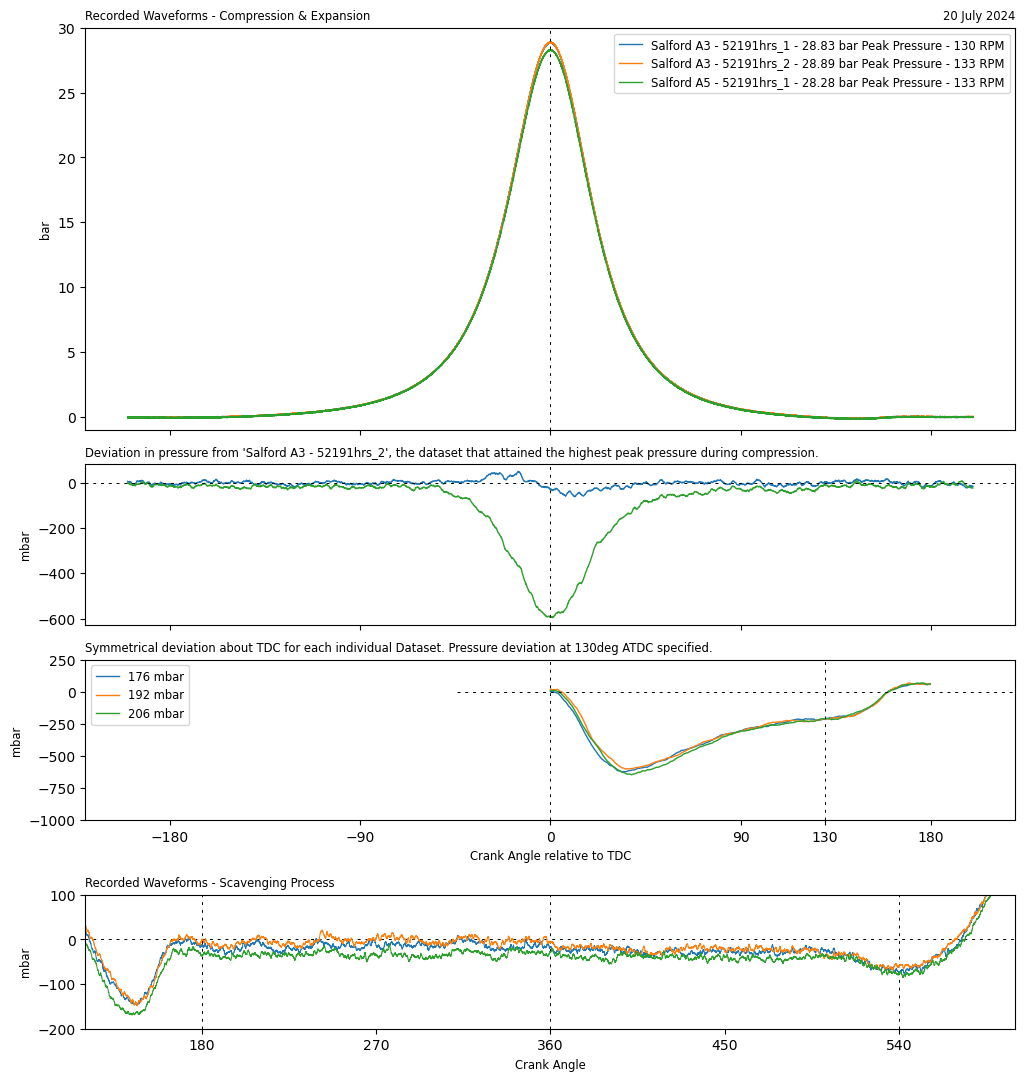

In [4]:
ColourPlotCounter = 0 # used for graph color
GraphEnable = False # 3 or 4 plot boolean initalization. 
if len(ImportFileList) > 1: # If the number of datasets to be processed is greater than 1, turn the boolean value for graphenable to true. Ie calculates the deviation from the waveform with the max compression value. 
    GraphEnable = True

## Plot Title Generation - User defined or defaults to just the date. 
PlotTitle = input("\nType in the desired Plot Title ->   ")
#PlotTitle = "" # Unhash this line and hash the line above for speeding up development
if PlotTitle == "":
    PlotTitle = "%s"%(date.today().strftime("%d %B %Y"))
else:
    PlotTitle = "%s - %s"%(PlotTitle, date.today().strftime("%d %B %Y"))

PeakCompressionWaveformValue = 0 # setting up a default value to compare the peak pressure during compression against. 
PeakCompressionWaveformDictKey = "" # setting up a string variable for the file name of the waveform with the greatest peak pressure during compression
def MatLabFileProcessorAndCompression(File): # Primary function to open Matlab files, desample, extract one TDC event. Generate crank angle array. Recenter crank angle around TDC
    
    global SamplePeriodTime
    global DeSampleInput
    global DeSampleInputFreq
    global SampleLength
    global DeSampleInputValue
    global ColourPlotCounter
    global ExtractedDataSpan
    global CrankTeeth
    global SampleFreq
    global DeSampleFreq
    global MasterDatasetRecordArray
    global SampleDataPeakPressure
    global DataArray
    global CompressionWaveform
    global PressurePeaks
    global PeakFilterArray
    global PeakCompressionWaveformDictKey
    global PeakCompressionWaveformValue

    #### THIS FIRST SECTION LOADS THE DATASET AND DESAMPLES IT

    ImportData = SIO.loadmat("./%s"%(File),verify_compressed_data_integrity=False) # loading the MatLab File
    
    
    SamplePeriodTime = round(float(ImportData["Tinterval"][0]),13) # rounding to remove floating point errors. Tinterval is a dictionary key within import data. 
    SampleLength = int(ImportData.get("Length")) # Length - ie dataset length - = number of values in a dataset
    SampleFreq = int(1//SamplePeriodTime) # Calculating the Sample frequecy. 
    
        
    if SampleFreq <= DeSampleFreq: # if the file being processed has a lower sample frequency - use the files frquency. (very unlikly)
        DeSampleFreq = SampleFreq 

    
    DeSampleSpan = int(SampleLength*((DeSampleFreq)/SampleFreq)) # converting the new desample frequency to a dataset length. 
    
    DataArray = ImportData["A"] # Importing the first channel data (Pressure)
    Shape = DataArray.shape # used to reshape the array below
    if ImportData["Version"].shape[0] <= 2: # corrects the array depending on weather the file came from pico 6 or pico 7
        DataArray = np.reshape(DataArray,(Shape[0],Shape[1]))
    else:
        DataArray = np.reshape(DataArray,(Shape[1],Shape[0]))
            
    DataArray = np.squeeze(DataArray) # removes excess columns. 

    bArray = ImportData["B"] # Importing channel B (Crank)
    Shape = bArray.shape # used to reshape the array below
    if ImportData["Version"].shape[0] <= 2: # corrects the array depending on weather the file came from pico 6 or pico 7
        bArray = np.reshape(bArray,(Shape[0],Shape[1]))
    else:
        bArray = np.reshape(bArray,(Shape[1],Shape[0]))
            
    bArray = np.squeeze(bArray) # removes excess columns. 
    
    if np.max(bArray) == np.inf: # This function removes any +inf and -inf and replaces them with the max value in the measuring window, (automatically calaculated). 
        
        bArrayTemp = bArray.copy() # copy the array as not to back reference bArray. 
        bArrayTemp[np.isinf(bArrayTemp)]=0 # turns every +inf value to zero
        infReplacementValue = int(math.ceil(np.max(bArrayTemp))) # finds the max real value, rounds up to the nearest interger
        bArray[np.isinf(bArray)]=infReplacementValue # replaces all inf values in bArray with this new max. 
        infReplacementValueNeg = -abs(infReplacementValue) # defines the negative limit value
        bArray[np.isneginf(bArray)]=infReplacementValueNeg # applies this neg value to bArray -inf values. 

    DataArray = np.column_stack((DataArray,bArray)) # adds that to the overall data array containing all channels. 

   
    DataArray = signal.resample(DataArray,DeSampleSpan) # Scipy function to resample the dataset (does both columns at the same time)

    ### THIS SECTION CONVERTS THE PICKUP SIGNAL TO A CRANK ANGLE - ANGLE NOT PHASED CORRECTLY
    
    RPMPeaks = signal.find_peaks(np.squeeze(DataArray[:,1]), prominence=10) # finding the peaks within the crankangle signal
    
    CrankAnglePerTooth = round(float(360/CrankTeeth),6) # calculating the angle each crank tooth represents to 6dp. 
    CrankAngleFuctionCounter = 0 # Counter for FOR function below. # starts at zero (important with how for function is writen below that starts with index 1)
    CrankAngleArray = np.empty(RPMPeaks[0][0]) # generate an empty array the size required the intial section before the first crank peak is detected.  
    CrankAngleArray[:] = np.nan # Fill the empty with NaN

    for CrankTriggerIndex in RPMPeaks[0][1:]: # for each index position defined in the tuple from the find_peaks function do the following. Note it misses the first value, starts index position 1. 
        CrankAngleIndexWindowWidth = CrankTriggerIndex - RPMPeaks[0][CrankAngleFuctionCounter] # Calculates the difference between the value entered via the FOR function with the previous value in the tuple. Gives the window in number of cells. 
        if CrankAngleFuctionCounter == 0: # If its the first time the intial value is zero. 
            CrankAngleArrayTemp = np.linspace(0,CrankAnglePerTooth,CrankAngleIndexWindowWidth) # generate an array from zero to angle per tooth in a given number of cells. 
            CrankAngleFuctionCounter += 1
        else: # If the FOR loop has been around a few times the intial value of the temp array generated is the last value in the main CrankAngleArray thats being generated. 
            CrankAngleArrayTemp = np.linspace(CrankAngleArray[-1],(CrankAngleArray[-1]+CrankAnglePerTooth),CrankAngleIndexWindowWidth) # finds the last value in the crank array, uses it and it plus crank tooth to generate the next set of values in the array. 
            CrankAngleFuctionCounter += 1
        CrankAngleArray = np.append(CrankAngleArray,CrankAngleArrayTemp) # combine. 

    CrankAngleArrayTemp = np.empty(len(DataArray[:,1])-RPMPeaks[0][-1]) # Generating an array of NaN's to pad out the end after the last peak. (Nan before is done before the for loop)
    CrankAngleArrayTemp[:] = np.nan
    CrankAngleArray = np.append(CrankAngleArray,CrankAngleArrayTemp) # combining the array and padding

    DataArray[:,1] = CrankAngleArray # replacing the pickup values with crank values

    ### THE ABOVE RESULTS IN A MASTER ARRAY FOR THAT DATASET THATS BEEN DESAMPLED AND REFERENCED TO CRANK ANGLE

    ### THE BELOW MAKES A COPY OF THAT DATASET AND TRIMS IT DOWN TO JUST AROUND THE COMPRESSION WAVEFORM

    CompressionWaveform = DataArray.copy() # COPY THE ARRAY
    
    PeakFilterArray = CompressionWaveform.copy()[:,0] # MAKING ANOTHER COPY THAT A FILTER CAN BE APPLIED TO AND THE PEAKS FOUND. REDUCES THE DETECTION OF FALSE PEAKS DUE TO NOISE
    PeakFilterArray = signal.savgol_filter(PeakFilterArray, 800, 1, mode="mirror", deriv=0) # This filter is used to remove any noise that effects the peak finding function below. ie find true peak.  
    PeakFilterArray = PeakFilterArray[:].round(decimals = 2) # rounds the above so end up with a wide platau at the top of the compression waveform instead of a noisy peak. Peak function returns the middle of the platau. 
    PressurePeaks = signal.find_peaks(np.squeeze(PeakFilterArray), prominence=10) # find peaks within the signal with a prominance of 5bar
    #print(PressurePeaks) # Just for testing. 
    NegExtractedDataSpan = -abs(ExtractedDataSpan) # GENERATING A NEGATIVE VALUE OF THE SPAN DEFINED AT THE VERY TOP OF THE SCRIPT
    
    if len(PressurePeaks[0]) >= 3:
        CompressionPeakIndex = int(PressurePeaks[0][1]) # find the index of the Compression TDC event
        SampleDataPeakPressure = round(DataArray[CompressionPeakIndex,0],2) # Extract the peak pressure value - used within the plot later on. 
        RPM = int(60/(((PressurePeaks[0][2] - PressurePeaks[0][1])/2)/DeSampleFreq)) # Calculting the RPM via the index position of 2 peaks, 2 revoltions apart, and the sample frequency. 
            ## do the crank angle offset here
        CrankOffsetRequired = 0-CompressionWaveform[CompressionPeakIndex,1] # Calculates the offset required to align crank angle 0 with TDC
        CompressionWaveform[:,1] = CompressionWaveform[:,1] + CrankOffsetRequired # Applied the offset to the crank angle data
            ## use the where function to find angles either side for the crop function at the bottom here
        
        LeftIndex = np.where(CompressionWaveform[:,1] <= NegExtractedDataSpan)[0][-1] # finds the index positions of the crank angle about TDC as defined at the top of the script
        RightIndex = np.where(CompressionWaveform[:,1] >= ExtractedDataSpan)[0][0]

        CompressionWaveform = CompressionWaveform[LeftIndex:RightIndex,:] # uses these crank angle index positions to trim the dataset. 
       

        
    ## I THINK THIS BELOW NEEDS ADJUSTING OR LOOKING AT. Broadgreen dataset. 
    elif len(PressurePeaks[0]) == 2:
        CompressionPeakIndex = int(PressurePeaks[0][0]) # find the index of the Compression TDC event
        SampleDataPeakPressure = round(DataArray[CompressionPeakIndex,0],2) # Extract the peak pressure value - used within the plot later on. 

        RPM = int(60/(((PressurePeaks[0][1] - PressurePeaks[0][0])/2)/DeSampleFreq)) # Similar RPM measuremet. Only using peaks 2 revoluations apart due to fewer peaks captured in the waveform. 
        CrankOffsetRequired = 0-CompressionWaveform[CompressionPeakIndex,1] # Calculates the offset required to align crank angle 0 with TDC
        CompressionWaveform[:,1] = CompressionWaveform[:,1] + CrankOffsetRequired
        
        
        LeftIndex = np.where(CompressionWaveform[:,1] <= NegExtractedDataSpan)[0][-1]
        RightIndex = np.where(CompressionWaveform[:,1] >= ExtractedDataSpan)[0][0]
        CompressionWaveform = CompressionWaveform[LeftIndex:RightIndex,:]


    Ax1.plot(CompressionWaveform[:,1],CompressionWaveform[:,0],color= CMAP[ColourPlotCounter],lw=1, label="%s - %s bar Peak Pressure - %s RPM"%(File[6:-4],SampleDataPeakPressure, RPM)) # Plot
    
    plt.ylim(bottom=-1, top=30) # Axis data for that column from the GlobalYAxisPlotValues. Ensures scaling on the plot
   
    

    if SampleDataPeakPressure > PeakCompressionWaveformValue: # function that compares the peak pressure with the one stored in a global variable. If larger it replaces a string value with this files filename. Used as a key later on. 
        PeakCompressionWaveformDictKey = "%s"%(File[6:-4])
        PeakCompressionWaveformValue = SampleDataPeakPressure # updates the comparator. 

    #Exporting
    MasterDatasetRecordArray[File[6:-4]]=[DataArray,CompressionWaveform,CMAP[ColourPlotCounter]] # saving the dataset (as an array) and color used for the plot within a dictionary with the filename as a key. 
    ColourPlotCounter += 1
    return DataArray # Ooutput of the function

## Generating the base plot

## The plotting makes use of a invisible graph (Ax4) that is used as a spacer between plots 3 and 4 displayed. This is due to the axis label and title of the 4th plot overlapping. Defined better within my notes. 

if GraphEnable == True:
    fig = plt.figure(figsize = (12,13)) 
    Ax1, Ax5, Ax2, Ax4, Ax3 = fig.subplots(5, 1,  gridspec_kw=dict(height_ratios=[3, 1.2,1.2,0.04,1]))
    
else:
    fig = plt.figure(figsize = (12,10)) 
    Ax1, Ax2, Ax4, Ax3 = fig.subplots(4, 1,  gridspec_kw=dict(height_ratios=[3, 1.2,0.04,1]))

    

Ax4.axis("off") # turn the axis off - ie not visible but takes up volume due to the ratio dimension given above. 
plt.sca(Ax1) ## all plot stuff below is in reference to axis 1
plt.ylim(bottom=-1, top=30) #setting y limits on axis 1
   

##  Initial plot labelling and Y axis generation


MasterDatasetRecordArray = {} # presetting dictionary the data is saved within. 


for a in ImportFileList: # running the main processor function for all the selected files. 
    OutputArray = MatLabFileProcessorAndCompression(a)

## PLOTTING PARAMETERS FOR TOP PLOT

plt.title(PlotTitle, loc="right", fontsize = "small")
plt.title("Recorded Waveforms - Compression & Expansion", loc="left", fontsize = "small")
plt.axvline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # Generates a vertical line, top to bottom at a x position of zero.
plt.xticks(ticks=[-180, -90, 0, 90, 180])
plt.gca().set_xticklabels([])
plt.xlim(-220,220)

plt.ylabel("bar",fontsize = "small") #Primary Y axis UNIT label inserted. PhasingColumn-1 used to get correct list indexing position. 
plt.legend(fontsize = "small")




DataSetKeys = MasterDatasetRecordArray.keys() # variable defining the keys within the saved dictionary from the previous function. THIS IS NOT A LIST. Tuple. 


####### DEVIATION FROM WAVEFORM WITH MAX PEAK PRESSURE
if GraphEnable == True: # ie if theres more than 1 dataset being processed

    plt.sca(Ax5) # now all plt commands are related to axis 5


    WaveformDeviKeys = list(DataSetKeys) # turns that into a list so it can be more readily worked/accessed
    WaveformDeviKeys.remove(PeakCompressionWaveformDictKey) # removes the reference dataset from that list (ie the dataset the others will be compared to)

    DeviationArray = np.arange(-200,200,0.1) # generating an angle array. 
    DeviationArrayPad = np.full_like(DeviationArray,0) # an array for use in the for loop below. 

    DeviationColorMap = []
    for A7 in WaveformDeviKeys: # A7 is a non variable, means nothing. Ie for every dataset (apart from reference) in the dictionary add an empty column to the array. 
        DeviationArray = np.column_stack((DeviationArray,DeviationArrayPad)) # add a column to the output array for data to later be added to
        DeviationColorMap.append(MasterDatasetRecordArray[A7][2]) # log in a list the color of the line of the dataset in the order they will be plotted. keeps the colors matched between plots. 

    def DeviationFromReference(Value,Keys,ReferenceKey): # function finds the pressure value for a given angle. fucntion is run for every angle within the deviation array. 
        global MasterDatasetRecordArray
        OutputArray = np.empty(0) # initlise an empty array to append to at the end. 

        # get the reference value
        RefIndex = np.where(MasterDatasetRecordArray[ReferenceKey][1][:,1] >= Value)[0][0] # uses the reference key from before to look at the correct dataset. finds the index position for finding the value below at a given angle. 
        RefValue = MasterDatasetRecordArray[ReferenceKey][1][RefIndex,0]

        for Array in Keys: # go through all the datasets and find the difference from the reference at a given crank angle position
            AveSamplePoint = np.where(MasterDatasetRecordArray[Array][1][:,1] >= Value)[0][0] # finds index position of pressure at a given angle
            SampleValue = MasterDatasetRecordArray[Array][1][AveSamplePoint,0] # finds pressure at that index.
            Deviation = int((SampleValue - RefValue)*1000) # calcaules deviation, multiples by 1000 to turn into mbar. 
            
            OutputArray = np.append(OutputArray,Deviation)
        
        return OutputArray

    for Deg in DeviationArray[:,0]:
        
        DeviationArrayInsert = DeviationFromReference(Deg,WaveformDeviKeys,PeakCompressionWaveformDictKey) # getting the deviations for the given angle
        DeviationArrayPoint = np.where(DeviationArray[:,0]==Deg)[0][0] # index position where to reinsert it
        DeviationArray[DeviationArrayPoint,1:(len(WaveformDeviKeys)+1)]=DeviationArrayInsert # inserting array. 


    DeviColourPlotCounter = 0
    DeviationPlotLenth = DeviationArray.shape[1] # this gives a length, not index position. this results in < AvePlotLength instead of <=
    DeviationPlotBoolean = True
    DeviationPlotCounter = 1 # 1 due to only starting on the 2rd column - due to size and shape of AveArray
    while DeviationPlotBoolean == True:
        if DeviationPlotCounter < DeviationPlotLenth:
                       
            FilteredDeviationPlot = signal.savgol_filter( DeviationArray[:,DeviationPlotCounter], 20, 1, mode="mirror", deriv=0) # filting the result to make it a little smoother. 
            plt.plot(DeviationArray[:,0],FilteredDeviationPlot,color= DeviationColorMap[DeviColourPlotCounter],lw=1)
            
            DeviColourPlotCounter += 1
            DeviationPlotCounter += 1
        elif DeviationPlotCounter >= DeviationPlotLenth:
            DeviationPlotBoolean = False


    plt.title("Deviation in pressure from '%s', the dataset that attained the highest peak pressure during compression."%(PeakCompressionWaveformDictKey), loc="left", fontsize = "small")
    plt.axvline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # Generates a vertical line, top to bottom at a x position of zero.
    plt.axhline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # hoizontal line about y= 
    plt.xticks(ticks=[-180, -90, 0, 90, 180])
    plt.gca().set_xticklabels([])
    plt.xlim(-220,220)

    plt.ylabel("mbar",fontsize = "small") #Primary Y axis UNIT label inserted. PhasingColumn-1 used to get correct list indexing position. 
    #plt.legend(fontsize = "small")





#### SYMETRICAL DEVIATION GRAPHS    


plt.sca(Ax2) # now all plt commands are related to axis 2

ColourPlotCounter = 0
def SymDeviation(Key): # function finds the pressure for a given angle each side of tdc and calculates the difference. calculated on a dataset by dataset basis. 
    global MasterDatasetRecordArray
    global ColourPlotCounter

    Dataset = MasterDatasetRecordArray[Key][1] # Compression waveform is brought in with this function. 

    SymDatasetOutput = np.array([0,0], ndmin=2) # generate an single array with 0. acts as the angle at tdc. 
    SymInterval = 0.25

    #       CONSIDER APPLYING A FILTER TO THE PRESSURE WAVEFORM BEFORE TAKING VALUES. - COULD BE DONE INSTEAD OF FILTER AFTERWARDS

    for deg in np.arange((0+SymInterval),180,SymInterval): # ie for each value between 0+the interval (ie to be the second row in the sysdatasetouput array) and 180. 
        deg = round(deg,2) # rounds the degree to 2dp - removes floating point errors
        InvertDeg = -abs(deg) # this returns the same amplitude but inverted. ie negative. 
        
        PosIndex = np.where(Dataset[:,1] >= deg)[0][0] # getting the index position for the positive angle
        NegIndex = np.where(Dataset[:,1] <= InvertDeg)[0][-1] # index position for the negative
        delta = round((Dataset[PosIndex,0] - Dataset[NegIndex,0])*1000,0) # getting the pressures at those index positions, subtracking them to get the delta. multiply by 1000 to get into mbar. 
        SymInsertArray = np.array([deg,delta],ndmin=2) # generating an array 
        
        SymDatasetOutput = np.append(SymDatasetOutput,SymInsertArray,axis=0) # adding it to the array generated before.
    
    #SymDatasetArrayMinIndex = np.argmin(SymDatasetOutput[:,1]) # argmin gives the index position of the min point. 
    
    SymDatasetArrayMinIndex = np.where(SymDatasetOutput[:,0] >= MeasurementAngle)[0][0] # This gives the deviation at a specific crank angle, ie 130 in this case just before the exhaust opens. 
    SymDatasetArrayMin = int(abs(SymDatasetOutput[SymDatasetArrayMinIndex,1])) # value for the plot label
    
    
    FilteredSymPlot = signal.savgol_filter(SymDatasetOutput[:,1], 20, 1, mode="mirror", deriv=0) # filter the deviation recordings
        
    plt.plot(SymDatasetOutput[:,0],FilteredSymPlot, color= CMAP[ColourPlotCounter],lw=1, label="%s mbar"%(SymDatasetArrayMin) ) # plot it. 
    ColourPlotCounter +=1

Key = MasterDatasetRecordArray.keys()
Key = list(Key)

for A9 in Key:
    SymDeviation(A9)

plt.legend(fontsize = "small", loc=2)

plt.title("Symmetrical deviation about TDC for each individual Dataset. Pressure deviation at %sdeg ATDC specified."%(MeasurementAngle), loc="left", fontsize = "small")
plt.ylabel("mbar",fontsize = "small")
plt.ylim(bottom=-1000, top=250) # Y limits
plt.axvline(MeasurementAngle, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) #Vertical Line
plt.axvline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) #Vertical Line
plt.axhline(0, 0.4,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # Horizontal Line
plt.xlabel("Crank Angle relative to TDC", fontsize = "small") # X axis label applied
plt.xticks(ticks=[-180, -90, 0, 90, MeasurementAngle, 180]) # Tick Locations. 
plt.xlim(-220,220)



####   Scavenging Process


plt.sca(Ax3)  # all plot functions below are applied to axis 3.

ColourPlotCounter = 0 # used for plot color
SavgolFilterWindow = 100 # Filter window size for filter within MatLabFileProcessorScavenge


def Scavenge(Key): # Primary function to extract data from dictionary, find a cycle, adjust crank angle, extract, filter, plot
    
    global SamplePeriodTime
    global DeSampleInput
    global DeSampleInputFreq
    global SampleLength
    global DeSampleInputValue
    global ColourPlotCounter
    global ExtractedDataSpan
    global CrankTeeth
    global SampleFreq
    global DeSampleFreq
    global MasterDatasetRecordArray
    global SampleDataPeakPressure
    global SavgolFilterWindow
    global DataArrayShape
    
    DataArray = MasterDatasetRecordArray[Key][0] # Get the data from the dictionary made within the first function. Imports the full desampled dataset. 

 
    ## Finding peaks of pressure - used to extract one TDC event
    PeakFilterArray = DataArray.copy()[:,0] # MAKING ANOTHER COPY THAT A FILTER CAN BE APPLIED TO AND THE PEAKS FOUND. REDUCES THE DETECTION OF FALSE PEAKS DUE TO NOISE
    PeakFilterArray = signal.savgol_filter(PeakFilterArray, 500, 1, mode="mirror", deriv=0)  # Filtering to find the peaks more precisly. reduces noise for the peak function below. 
    PressurePeaks = signal.find_peaks(np.squeeze(PeakFilterArray), prominence=5) # find peaks within the signal with a prominance of 5bar
    

    LeftPeak = int(PressurePeaks[0][0]) # find the index of the first TDC event
    RightPeak = int(PressurePeaks[0][1]) # find the index of the second TDC event
    
    CrankOffsetRequired = 0-DataArray[LeftPeak,1] # Calculates the offset required to align crank angle 0 with TDC of the first peak. 
    DataArray[:,1] = DataArray[:,1] + CrankOffsetRequired # applies offset to the crank angle array. 
    
    
    DataArray = DataArray[LeftPeak:RightPeak,:] # extract the relvent section of the dataset 
    DataArray[:,0] = DataArray[:,0]*1000 # gets pressure values into mbar. 
    
    DataArray[:,0] = signal.savgol_filter(DataArray[:,0], SavgolFilterWindow, 1, mode="mirror", deriv=0) # Filter. 1st order polynomial
    #DataArrayShape = DataArray.shape # Variable called for in the title of this section of the graph. 
    # Crank Angle Scale
            
## Simply relies on the previous function extracting just the data between the two peaks and then generating an array from 0-720 across an array the same length of the extracted data. 
  
    

##PLotting
    
    Ax3.plot(DataArray[:,1],DataArray[:,0],color= CMAP[ColourPlotCounter],lw=0.75) # Plot
    
    plt.ylim(bottom=-200, top=100) # Axis data for that column from the GlobalYAxisPlotValues. Ensures scaling on the plot
    plt.xlim(120,600)
        
    
    ColourPlotCounter += 1 # increments colour counter for the next dataset. 



plt.ylim(bottom=-200, top=100) #setting y limits
plt.axhline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # hoizontal line about y= 
plt.axvline(360, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # vertical line about x=360
plt.axvline(180, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # vertical line about x=180
plt.axvline(540, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # vertical line about x=540  


for a in Key: # running the main processor function for the valve overlap Scavenge Process for all the selected files. 
    OutputArray = Scavenge(a)



plt.title("Recorded Waveforms - Scavenging Process", loc="left", fontsize = "small")
plt.axvline(0, 0,1, linestyle="--", lw=0.7, c="black", dashes=(3, 5)) # Generates a vertical line, top to bottom at a x position of zero.

plt.ylabel("mbar",fontsize = "small") #Primary Y axis UNIT label inserted. PhasingColumn-1 used to get correct list indexing position. 

plt.xlabel("Crank Angle", fontsize = "small") # X axis label applied
plt.xticks(ticks=[180,270,360,450,540]) # Defining the Ticks for the X Axis


plt.savefig("%s/%s.pdf"%(OutputFilePath, PlotTitle), format="pdf")

plt.show()




